# **Titanic (lightGBM classifier)**
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/* * * notebook/lightgbm_classifier_titanic.ipynb
* kaggle: https://www.kaggle.com/c/titanic
* lightgbm: https://lightgbm.readthedocs.io/en/latest/


* author: Prasert Kanawattanachai
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* Chulalongkorn Business School

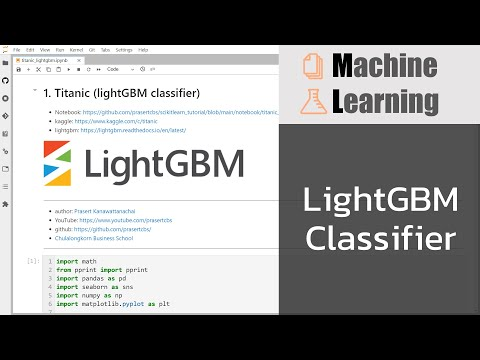

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('yJKRTZW_juc', width=720, height=405)

In [2]:
import math
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.1.5
numpy   version: 1.19.5
seaborn version: 0.11.1


## **utility functions**

In [5]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)

data
Variable	Definition	Key
Survived	Survival	0 = No, 1 = Yes
Pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
Sex	Sex	
Age	Age in years	
SibSp	# of siblings / spouses aboard the Titanic	
Sibling = brother, sister, stepbrother, stepsister	
Spouse = husband, wife (mistresses and fiancés were ignored)	
Parch	# of parents / children aboard the Titanic	
Parent = mother, father	
Child = daughter, son, stepdaughter, stepson	
Some children travelled only with a nanny, therefore parch=0 for them.	
Ticket	Ticket number	
Fare	Passenger fare	
Cabin	Cabin number	
Embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [6]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
384,385,0,3,"Plotcharsky, Mr. Vasil",male,NaN,0,0,349227,7.8958,NaN,S
501,502,0,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q
613,614,0,3,"Horgan, Mr. John",male,NaN,0,0,370377,7.7500,NaN,Q
691,692,1,3,"Karun, Miss. Manca",female,4.0,0,1,349256,13.4167,NaN,C
695,696,0,2,"Chapman, Mr. Charles Henry",male,52.0,0,0,248731,13.5000,NaN,S
768,769,0,3,"Moran, Mr. Daniel J",male,NaN,1,0,371110,24.1500,NaN,Q
281,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S
288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## **convert obj/string columns to category data type for lightGBM**

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
cols_to_cat=['Pclass', 'Sex', 'Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.7+ KB


In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

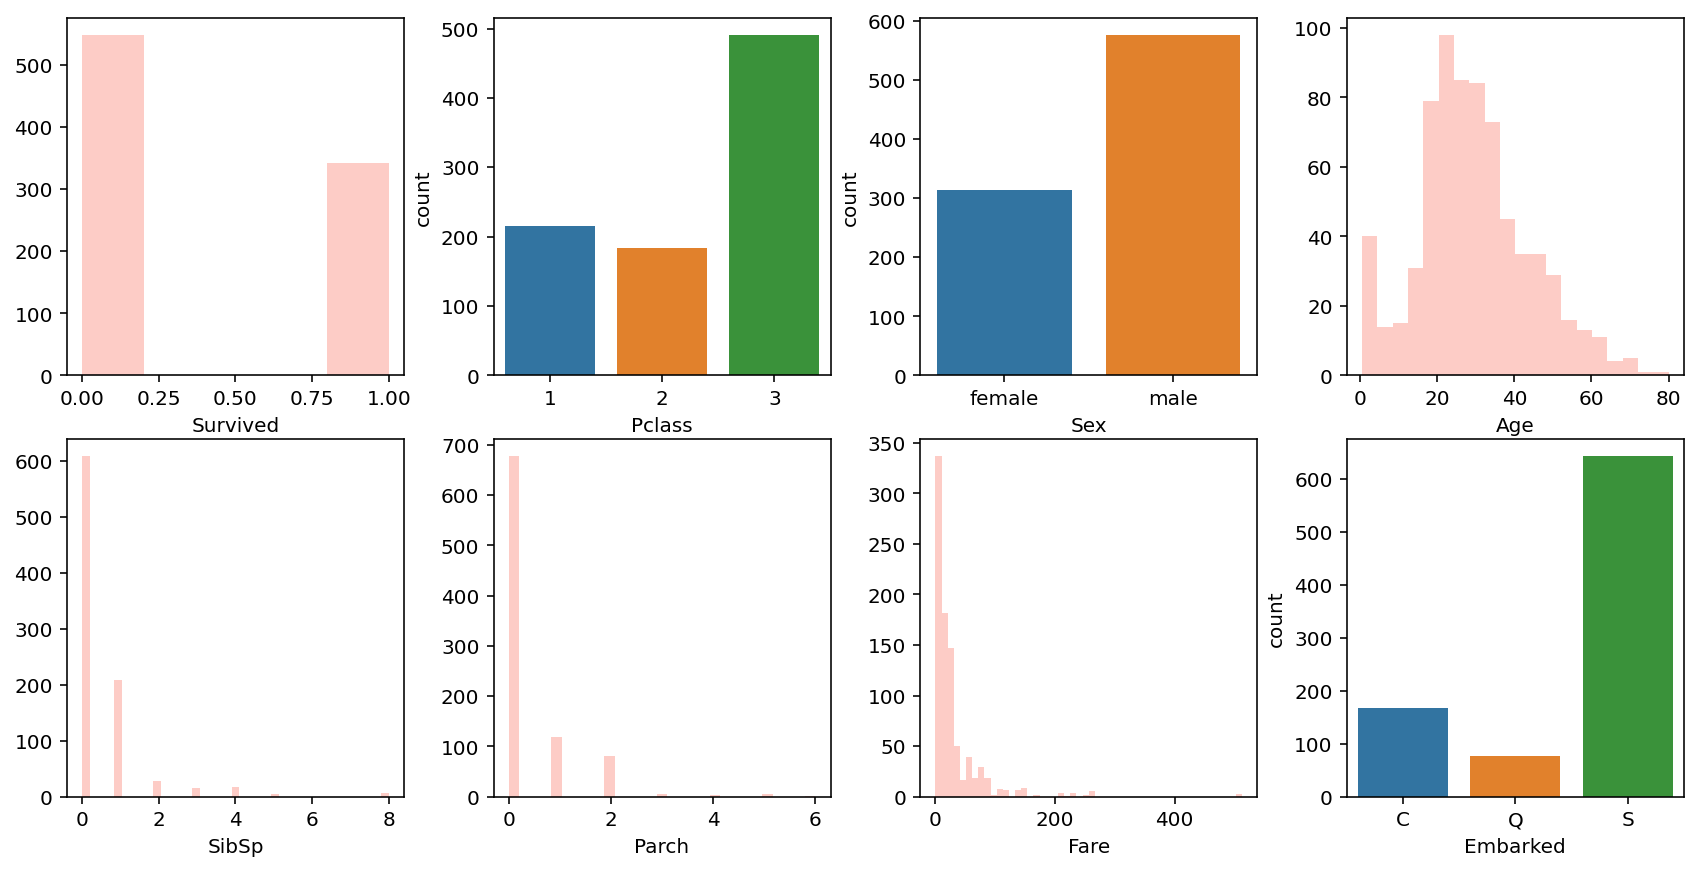

In [12]:
cols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

# **lightgbm**
* lightGBM doc: https://lightgbm.readthedocs.io/en/latest/
* LGBMClassifier: https://lightgbm.readthedocs.io/en/latest/pythonapi/
* lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
how to install lightgbm

* pip: pip install -U lightgbm
* conda: conda install lightgbm

In [13]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 2.2.3


In [14]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [15]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
feature_cols=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1, 
                                                    stratify=y)

In [18]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [19]:
clf=lgb.LGBMClassifier()

In [20]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [21]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# clf = lgb.LGBMClassifier(**params)

In [22]:
# eval_metric: https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=metric#metric-parameters
fit_params={'early_stopping_rounds':20, 
            'eval_metric': 'auc', # [binary_logloss, auc]
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }

clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.459297	valid_0's auc: 0.864427
[20]	valid_0's binary_logloss: 0.423355	valid_0's auc: 0.864163
[30]	valid_0's binary_logloss: 0.417107	valid_0's auc: 0.866271
[40]	valid_0's binary_logloss: 0.421437	valid_0's auc: 0.865152
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.420427	valid_0's auc: 0.86805


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
clf.__dict__

{'_Booster': <lightgbm.basic.Booster at 0x7f116631cb50>,
 '_best_iteration': 24,
 '_best_score': defaultdict(dict,
             {'valid_0': {'auc': 0.8680500658761529,
               'binary_logloss': 0.4204273585595824}}),
 '_classes': array([0, 1]),
 '_evals_result': {'valid_0': defaultdict(list,
              {'auc': [0.8516469038208169,
                0.853030303030303,
                0.8610671936758894,
                0.8586956521739131,
                0.863965744400527,
                0.8616600790513834,
                0.8604743083003953,
                0.8620553359683795,
                0.8631093544137023,
                0.8644268774703557,
                0.8596837944664032,
                0.8607378129117259,
                0.8657444005270092,
                0.8671277997364953,
                0.8656126482213439,
                0.8649538866930171,
                0.8621870882740448,
                0.8647562582345191,
                0.866798418972332,
            

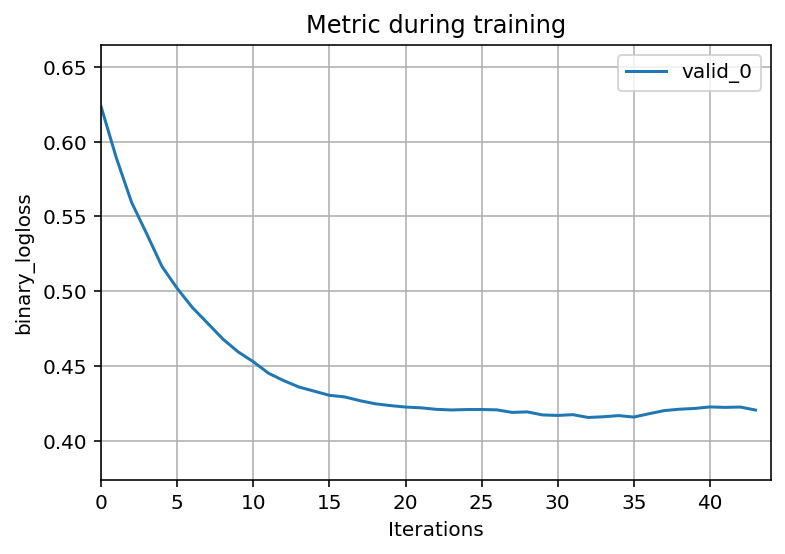

In [24]:
lgb.plot_metric(clf, metric='binary_logloss')

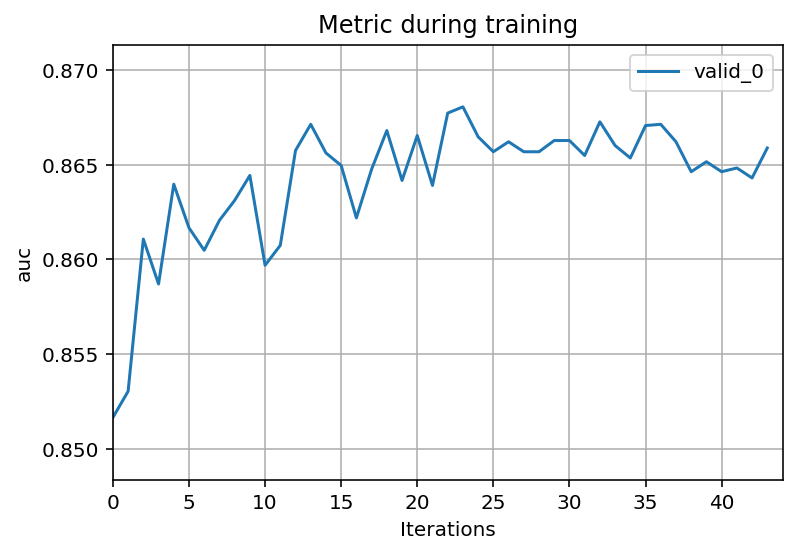

In [25]:
lgb.plot_metric(clf, metric='auc')

In [26]:
clf.score(X_train, y_train) # classification accuracy score

0.8567415730337079

In [27]:
clf.score(X_test, y_test) # classification accuracy score

0.8212290502793296

In [28]:
clf.predict(X_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [29]:
clf.predict_proba(X_test)[:20]

array([[0.90844705, 0.09155295],
       [0.7856398 , 0.2143602 ],
       [0.86549359, 0.13450641],
       [0.9420143 , 0.0579857 ],
       [0.87057259, 0.12942741],
       [0.90844705, 0.09155295],
       [0.87005272, 0.12994728],
       [0.59634552, 0.40365448],
       [0.94638891, 0.05361109],
       [0.84992437, 0.15007563],
       [0.12758296, 0.87241704],
       [0.59634552, 0.40365448],
       [0.70618226, 0.29381774],
       [0.92167319, 0.07832681],
       [0.06820815, 0.93179185],
       [0.7856398 , 0.2143602 ],
       [0.89850147, 0.10149853],
       [0.10918986, 0.89081014],
       [0.42496777, 0.57503223],
       [0.94638891, 0.05361109]])

## **confusion matrix**
$$
\begin{bmatrix}
C_{0,0} &amp; C_{0,1} \\
C_{1,0} &amp; C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&amp;fp \\
fn&amp;tp
\end{bmatrix}
$$
predicted false	predicted true
actual false	tn	fp
actual true	fn	tp


In [30]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

array([[99, 11],
       [21, 48]])

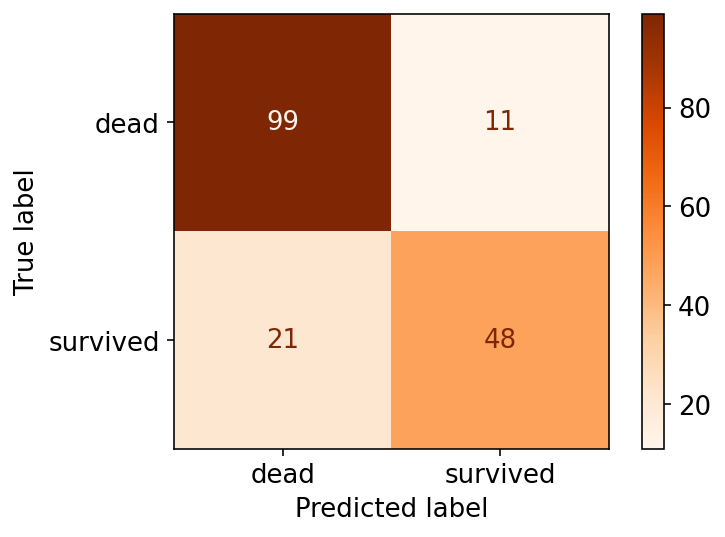

In [31]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived']);

$$
\begin{align}
\text {Accuracy}&amp;={\frac {{TP+TN} }{TP + TN +FP + FN} }\\
\text {Precision}&amp;={\frac {TP}{TP+FP}}\\
\text {Recall, True Positive Rate (TPR), sensitivity}&amp;={\frac {TP}{TP+FN}}\\
\text {False Positive Rate (FPR), miss rate}&amp;={\frac {FP}{FP+TN}}\\
F1&amp;=2 \times {\frac {precision \times recall} {precision + recall}}\\
\end{align}
$$
$$
\begin{align}
Recall_0&amp;={\frac {TN}{TN+FP}}\\
Recall_1&amp;={\frac {TP}{TP+FN}}\\
Precision_0&amp;={\frac {TN}{TN+FN}}\\
Precision_1&amp;={\frac {TP}{TP+FP}}\\
\end{align}
$$

In [32]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       439
           1       0.86      0.75      0.80       273

    accuracy                           0.86       712
   macro avg       0.86      0.84      0.84       712
weighted avg       0.86      0.86      0.85       712



In [33]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

